# Productivity and GDP Data Analysis
__Cam Fraser__ <br>
_27/05/2022 - 08/05/2022_

In [3]:
import numpy as np
import pandas as pd
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The Brief

A task was set by Deliotte to answer:

#### How can we improve productivity within Scotland and the UK overall? 

This will involve answering the following questions:

1. How does the UK compare to other developed economies in terms of GDP and exports?

2. What factors might be important in predicting a country’s GDP?

3. Can you predict GDP estimates/growth for the upcoming year(s) from any of these factors?




# Methodology

## Comparing GDP by Country

Using the Global Financial Development Dataset - the GDP of countries can be attained, and allow comparison of developed economies namly countries in the G7.


## Predictive Modelling

To answer the questions 2 and 3, the variables are have a high level of colinearity so we can use them to predict GDP using forcasting.





---
# Analysis

### 1. How does the UK compare to other developed economies in terms of GDP and exports?

In this comparison, we will look at the members of the __Group of Seven__ (G7) which is an inter-governmental political forum consisting of the wealthiest and most economically developed democracies. The G7 consists of _Cananda, Germany, France, Italy, Japan, the United Kingdom and the United States_.

First, we need to load in the cleaned G7 data set and then analyse their GDP and exports.

### 2. What factors might be important in predicting a country’s GDP?

From the formula attained through research, there are three ways to calculate the GDP of a country:

– __Expenditure Approach__ –

Takes into account:

__Consumption__ = All private consumption/ consumer spending in the economy. It includes durable goods, nondurable goods, and services.<br>
__Investment__ = All of a country’s investment in capital equipment, housing, etc.<br>
__Government Spending__ = All of the country’s government spending. It includes the salaries of government employees, construction, maintenance, etc.<br>
__Net Export__ = Net country export – Net country import

In [4]:
# load in the dataset containing information on variables leading to gdp
uk_gdp_estimates = pd.read_excel("/Users/cameronfraser/CodeClan/producivity_&_gdp_project/raw_data/data/UK GDP Estimates - Time Series.xlsx", header=0, engine='openpyxl').iloc[6:]

# rename variables fpr ease of use later on
uk_gdp_estimates.rename(columns={
    
    "Title": "quarter",
    "Gross Domestic Product at market prices: Current price: Seasonally adjusted £m": "gdp",

    #for expenditure approach
    "Total gross final expenditure (aligned) - P.3+P.5+P.6 : CVM SA £m": "gov_consumption",
    "Household final consumption expenditure :National concept CVM SA - £m": "house_consumption",
    "Total Gross Fixed Capital Formation CVM SA £m": "investment",
    "Balance of Payments: Trade in Goods & Services: Total Balance: CVM SA £m": "net_exports",

    #for income approach
    "Gross National Income: Current price: Seasonally adjusted £m": "national_income",
    "Taxes less subsidies on products and production, cont Q on Q": "taxes",
    "Total national expenditure:Implied deflator:SA": "depreciation",
    "Net income from abroad: Current price: Seasonally adjusted £m": "foreign_income"
}, inplace=True)

# Have to split this data up, as there is annual and quarterly data within it
uk_gdp_estimates_quarterly = uk_gdp_estimates[uk_gdp_estimates["quarter"].str.contains("Q")][:]


### Data set on income taxes for the UK for use in the income appraoch
uk_income_tax = pd.read_csv("/Users/cameronfraser/CodeClan/producivity_&_gdp_project/raw_data/data/uk_income_tax_1996_2022.csv").loc[53:152]

# rename columns for ease of use later on
uk_income_tax.rename(columns = {
    "Title": "quarter",
    "CG: Current receipts: Taxes on income: PAYE income tax: £m CPNSA": "income_tax"
}, inplace=True)
# Note its measured in £m

# Convert the quarter column to timeseries
uk_income_tax["quarter"] = pd.PeriodIndex(uk_income_tax["quarter"].str.replace(r' ', r''), freq='Q').to_timestamp()

/Users/cameronfraser/opt/anaconda3/envs/python39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
expenditure_approach_variables = uk_gdp_estimates_quarterly[["quarter", "gov_consumption", "house_consumption", "investment", "net_exports", "gdp"]][:]

expenditure_approach_variables["quarter"] = pd.PeriodIndex(expenditure_approach_variables["quarter"].str.replace(r' ', r''), freq='Q').to_timestamp()

expenditure_approach_variables.dropna(inplace=True)

expenditure_approach_variables.loc[:,("gov_consumption", "house_consumption", "investment", "net_exports", "gdp")] = expenditure_approach_variables.loc[:,("gov_consumption", "house_consumption", "investment", "net_exports", "gdp")].astype(float)

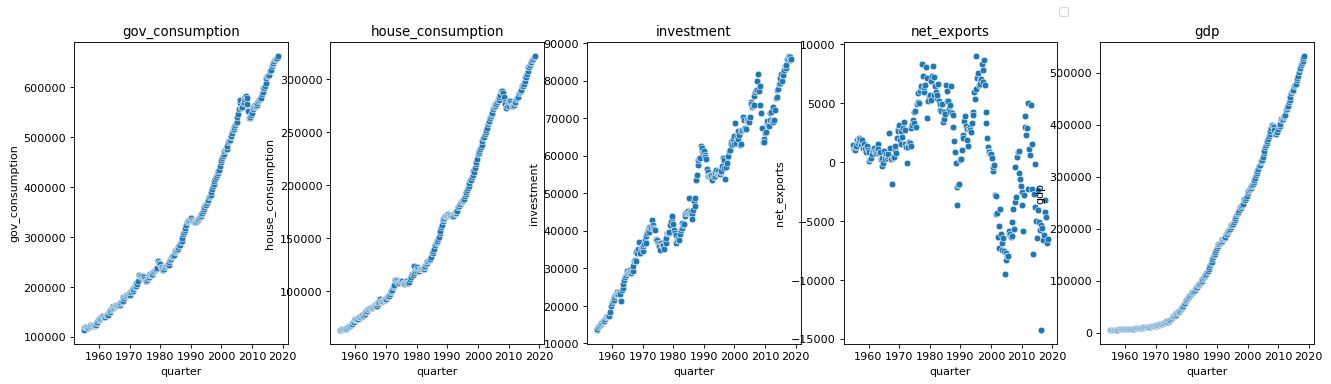

In [6]:
# create figure
fig = plt.figure(figsize=(20, 5), dpi=80)

# add subplots
for i, col in enumerate(expenditure_approach_variables.columns[1:], 1):
    plt.subplot(1, 5, i)
    ax = sns.scatterplot(x="quarter", y=col, data=expenditure_approach_variables)
    plt.title(col)

# add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(.75, 0.98))

# add subtitle
fig.suptitle('')

plt.show()

– __Income Approach__ –


__Total national income__ = Sum of rent, salaries profit.<br>
__Sales Taxes__ = Tax imposed by a government on sales of goods and services.<br>
__Depreciation__ = the decrease in the value of an asset. <br>
__Net Foreign Factor Income__ = Income earned by a foreign factor like the amount a foreign company or foreign person earns from the country. It is also the difference between a country’s citizens and country’s earn.

In [7]:
#Creating an income approach variable dataset

income_approach_variables = uk_gdp_estimates_quarterly[["quarter", "national_income", "depreciation", "foreign_income", "gdp"]][:]

income_approach_variables["quarter"] = pd.PeriodIndex(income_approach_variables["quarter"].str.replace(r' ', r''), freq='Q').to_timestamp()

income_approach_variables.dropna(inplace=True)

income_approach_variables = income_approach_variables.merge(uk_income_tax, on="quarter")[:]


income_approach_variables.loc[:,("national_income", "depreciation", "foreign_income", "gdp", "income_tax")] = income_approach_variables.loc[:,("national_income", "depreciation", "foreign_income", "gdp", "income_tax")].astype(float)

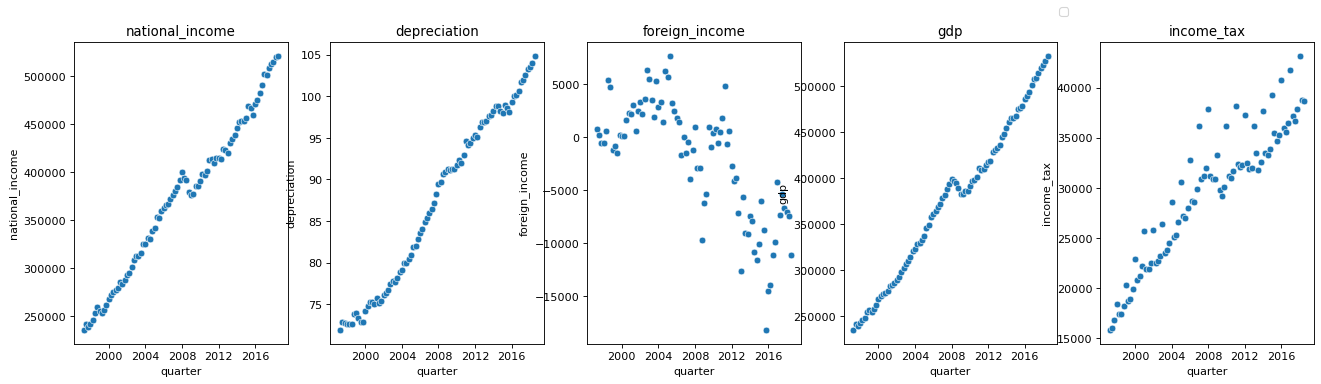

In [8]:
# create figure
fig = plt.figure(figsize=(20, 5), dpi=80)

# add subplots
for i, col in enumerate(income_approach_variables.columns[1:], 1):
    plt.subplot(1, 5, i)
    ax = sns.scatterplot(x="quarter", y=col, data=income_approach_variables)
    plt.title(col)

# add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(.75, 0.98))

# add subtitle
fig.suptitle('')

plt.show()

\- __Production or Value-Added Approach__ -

The reverse of the expenditure appraoch:

$ Gross\ Value\ Added\ =\ Gross\ Value\ of\ Output\ –\ Value\ of\ Intermediate\ Consumption $

$ GDP\ =\ Price\ of\ Output\ -\ Cost\ of\ Inputs$

GDP is calculated here as the sum of all value added to products during the production of a process



### 3. Can you predict GDP estimates/growth for the upcoming year(s) from any of these factors?

Now we can take the variables of that predict GDP, and using predictive modelling, predict future quarters and years of GDP.

– __Expenditure Approach__ –

GDP and it's expenditure variables have trends and are not stationary - i.e. there's no pattern to their changes over time and that it does change over time. Also to note, there are no missing values.

In [9]:
expenditure_for_predictions = pd.DataFrame()

expenditure_for_predictions = expenditure_approach_variables[:]

expenditure_for_predictions.index = expenditure_approach_variables["quarter"]

expenditure_for_predictions.drop(columns="quarter", inplace=True)

/var/folders/nr/2lvpnbdn1vb5_fbkj9m9jbh00000gn/T/ipykernel_73389/3486592004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditure_for_predictions.drop(columns="quarter", inplace=True)


In [10]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

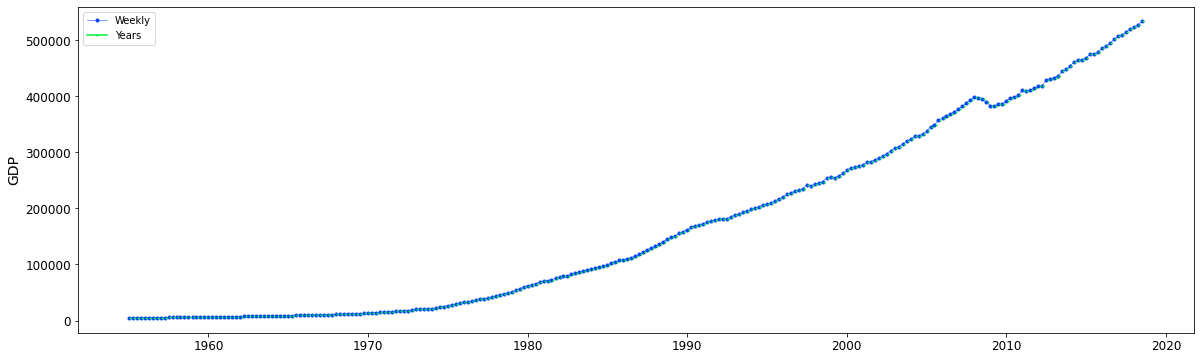

In [11]:
import warnings
import matplotlib.pyplot as plt
y = expenditure_for_predictions['gdp']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=1, linestyle='-', label='Years')
ax.set_ylabel('GDP')
ax.legend();

#Change the look of this graph

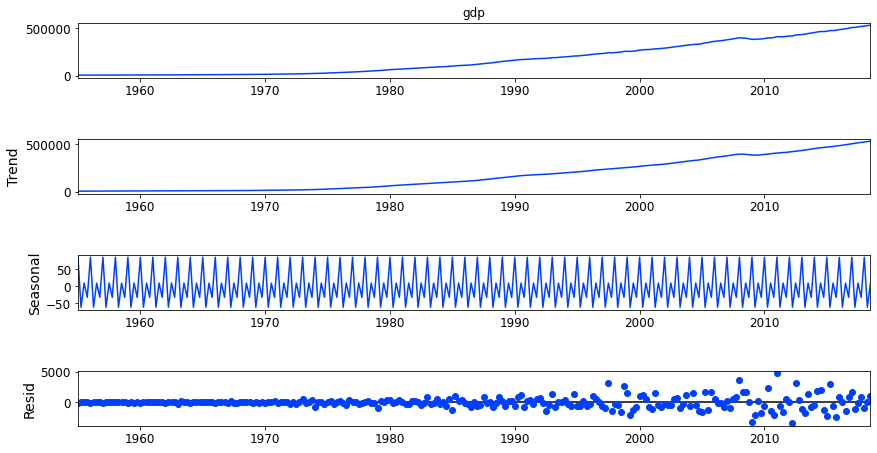

In [12]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
seasonal_decompose(y)

In [13]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")



for name, column in expenditure_for_predictions.iteritems():
    adfuller_test(column, name=column.name)

 gov_consumption : P-Value = 0.998 => Non-stationary.
 house_consumption : P-Value = 0.996 => Non-stationary.
 investment : P-Value = 0.848 => Non-stationary.
 net_exports : P-Value = 0.487 => Non-stationary.
 gdp : P-Value = 0.999 => Non-stationary.


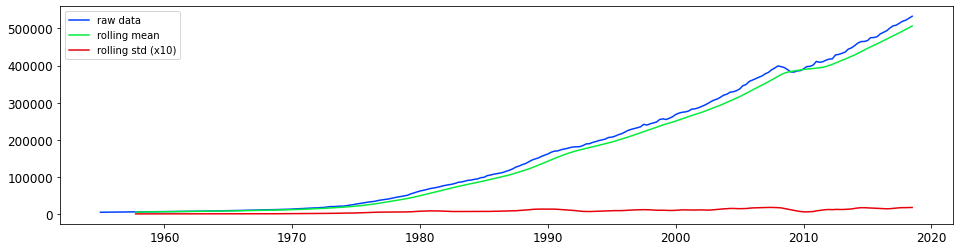

In [14]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [15]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

NameError: name 'y_detrend' is not defined

In [21]:
y_to_train = y[:int(0.9*(len(y)))] # dataset to train
y_to_val = y[int(0.9*(len(y))):] # last X months for test 

ValueError: use_boxcox was set at model initialization and cannot be changed

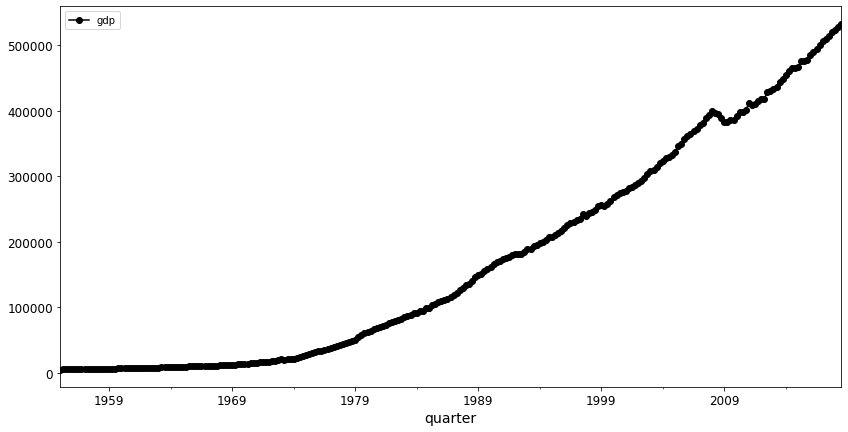

In [ ]:

 
predict_date = len(y) - len(y[:'2019-06-02']) # the number of data points for the test set

from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)


In [22]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43932D+00    |proj g|=  8.95060D-02


 This problem is unconstrained.



At iterate    5    f=  5.41568D+00    |proj g|=  4.91598D-02

At iterate   10    f=  5.41152D+00    |proj g|=  4.11043D-03

At iterate   15    f=  5.41148D+00    |proj g|=  3.91298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     31      1     0     0   2.750D-05   5.411D+00
  F =   5.4114795854777258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9957      0.009    113.230      0.000       0.978       1.013


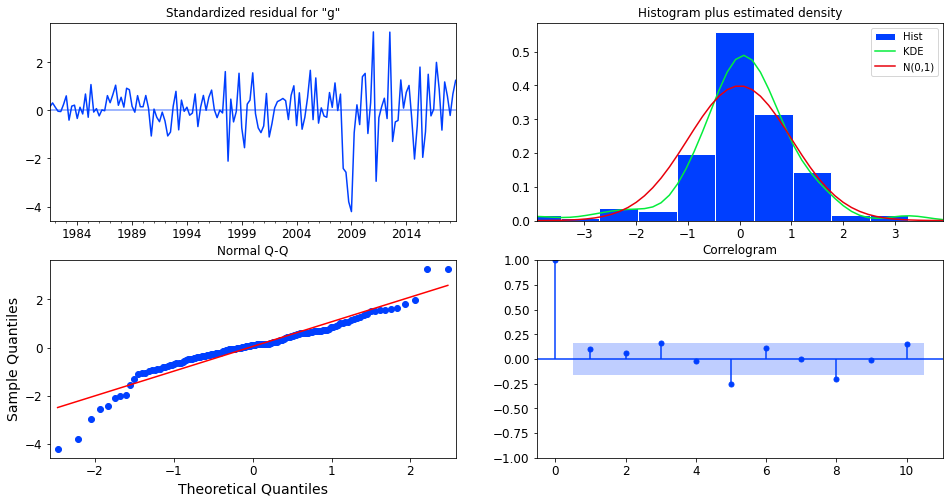

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False nan


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

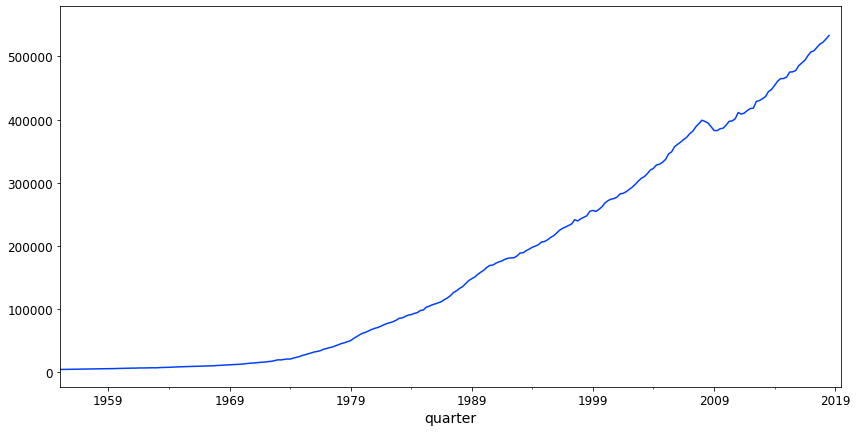

In [23]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2019-06-02',y_to_val)

In [25]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

final_table = forecast(model,52,y)
final_table.head()

NameError: name 'model' is not defined

In [181]:
data_differenced = expenditure_for_predictions.diff().dropna()
data_differenced2 = data_differenced.diff().dropna()
for name, column in data_differenced2.iteritems():
    adfuller_test(column, name=column.name)

#set the frequency for index
data_differenced2.index = pd.DatetimeIndex(data_differenced2.index.values,
                               freq=data_differenced2.index.inferred_freq)

 gov_consumption : P-Value = 0.0 => Stationary. 
 house_consumption : P-Value = 0.0 => Stationary. 
 investment : P-Value = 0.0 => Stationary. 
 net_exports : P-Value = 0.0 => Stationary. 
 gdp : P-Value = 0.0 => Stationary. 


In [185]:
#creating the train and test data sets
train_exp_pred_model = data_differenced2[:int(0.9*(len(data_differenced2)))]
test_exp_pred_model = data_differenced2[int(0.9*(len(data_differenced2))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train_exp_pred_model)
model_fit = model.fit()
# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=len(test_exp_pred_model))


In [193]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[train_exp_pred_model.columns])
for j in range(0,5):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

pred

,gov_consumption,house_consumption,investment,net_exports,gdp
0,-880.50381099,-992.96911045,529.11520259,-1102.49504124,318.12512216
1,682.36428035,699.45567541,-142.14098866,744.45646409,-87.21998371
2,-492.07099435,-477.39806956,-12.97012917,-468.21916572,54.33595374
3,334.16638153,331.39901011,67.39640909,310.28229090,-11.39303841
4,-227.11518429,-217.37713842,-73.87050283,-182.49839432,33.04874391
5,146.18114690,150.42299843,66.51184030,126.51903753,-3.29521264
6,-98.58706235,-93.33659625,-51.28819162,-65.99265940,27.09399505
7,60.25304810,66.60820237,39.79088625,53.35333355,2.51121044
8,-41.99788217,-37.41579087,-27.31474808,-20.34939204,21.61568287
9,23.39215501,29.71001440,20.58775726,25.01951425,7.27680225


– __Income Approach__ –

GDP and it's income variables have trends and are not stationary - i.e. there's no pattern to their changes over time and that it does change over time. One variable that might have cyclic trends is income_tax - this may be a problem later on. Also to note, there are no missing values.